# Proyecto 2 – Parte II (Core)
## **Proyecto 2: Análisis y Selección de Problema**

### **Parte II: Preprocesamiento y Optimización**

**Objetivo:** Realizar el preprocesamiento de datos y la optimización de modelos de machine learning para el conjunto de datos seleccionado. La meta es elegir la técnica de machine learning más adecuada y optimizar sus hiperparámetros para obtener el mejor rendimiento posible.

He seleccionado el datasets Heart desde Kaggle del siguiente link:

**Ataque al corazon:**
https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data?resource=download



In [1]:
# Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


**1. Limpieza de Datos:**
- Tratar los valores nulos utilizando técnicas adecuadas (imputación, eliminación, etc.).
- Manejar los outliers mediante técnicas de filtrado o transformación.

In [2]:
#Importo el dataset
df_heart = pd.read_csv('heart.csv')

In [3]:
# Analiso los datos
df_heart.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,NaN,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
# Validamos existencia de nulos. En este caso tenemos uno en la columna 'age'
df_heart.isnull().sum()

,0
age,1
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


In [5]:
# reemplazo el valor nulo por el promedio de edad por sexo
df_heart['age'].fillna(df_heart.groupby('sex')['age'].transform('mean'), inplace=True)


/tmp/ipython-input-5-467823585.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_heart['age'].fillna(df_heart.groupby('sex')['age'].transform('mean'), inplace=True)


In [6]:
# validamos que se haya imputado el valor
df_heart.isnull().sum()

,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


(array([1, 2, 3, 4, 5, 6, 7]),
 [Text(1, 0, 'age'),
  Text(2, 0, 'creatinine_phosphokinase'),
  Text(3, 0, 'ejection_fraction'),
  Text(4, 0, 'platelets'),
  Text(5, 0, 'serum_creatinine'),
  Text(6, 0, 'serum_sodium'),
  Text(7, 0, 'time')])

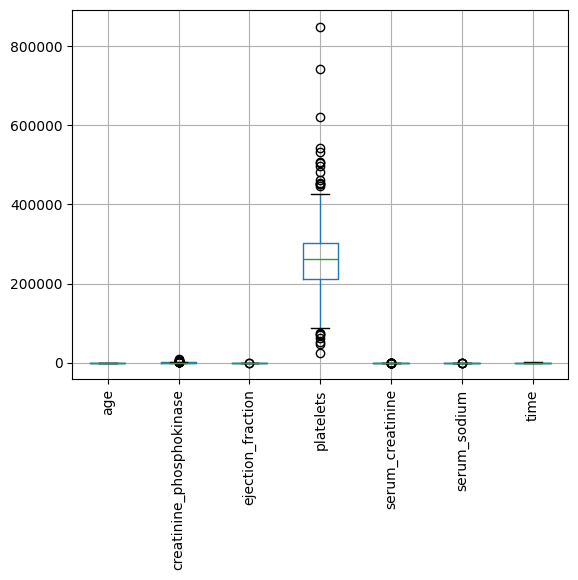

In [7]:
# boxplot para el df
df_heart.boxplot(column=['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time'])
plt.xticks(rotation=90)

In [8]:
df_heart["platelets"].describe()

,platelets
count,299.000000
mean,263358.029264
std,97804.236869
min,25100.000000
25%,212500.000000
50%,262000.000000
75%,303500.000000
max,850000.000000


Por desconocimiento de temas medicos, sin entender la forma de medicion y los valores correctos, aplicare cambios en la columna 'platelets' imputando la media de estos

In [9]:
# Imputamos promedio a todos los valores atipicos

# Calculamos el IQR
Q1 = df_heart['platelets'].quantile(0.25)
Q3 = df_heart['platelets'].quantile(0.75)
IQR = Q3 - Q1

# Definimos el largo del bigote
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

platelets_promedio = df_heart[(df_heart['platelets'] >= limite_inferior) & (df_heart['platelets'] <= limite_superior)]['platelets'].mean()
# Reemplazo el valor promedio a los outliers
df_heart['platelets'] = df_heart['platelets'].apply(lambda x: platelets_promedio if x < limite_inferior or x > limite_superior else x)

**Transformación de Columnas:**

- Utilizar ColumnTransformer para aplicar transformaciones específicas a diferentes columnas.
- Realizar codificación de variables categóricas utilizando técnicas como One-Hot Encoding.
- Escalar las variables numéricas usando StandardScaler u otros métodos de normalización.

In [10]:
# Definimos los predictores y el target
X = df_heart.drop('DEATH_EVENT', axis=1)
y = df_heart['DEATH_EVENT']

In [11]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Asigno las columnas numericas para su transformacion escalar
num_cols = X_train.columns.tolist()

In [15]:
# Definir transformadores.
num_cols

['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time']

In [20]:
# Defino el transformer para Tree
preprocessor_tree = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
])

# Defino el transformer para RF
preprocessor_rf = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
])

# Defino el transformer para KNN
preprocessor_knn = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
])

**Creación de Pipelines:**
- Crear pipelines utilizando Pipeline de sklearn para automatizar el preprocesamiento de datos y asegurar la reproducibilidad.
- Incluir todos los pasos de preprocesamiento en el pipeline.

Arbol de Decision

In [17]:
# Pipeline de Modelo Arbol de Decision
pipeline_tree = Pipeline([
    ("preprocessing", preprocessor_tree),
    ("model", DecisionTreeClassifier())
])

In [18]:
# Pipeline de Modelo Ramdom Forest
pipeline_rf = Pipeline([
    ("preprocessing", preprocessor_rf),
    ("model", RandomForestClassifier())
])

In [21]:
# Pipeline de Modelo K-Neighbors
pipeline_knn = Pipeline([
    ("preprocessing", preprocessor_knn),
    ("model", KNeighborsClassifier())
])

### **Parte 2: Selección de Técnica de Machine Learning**

**Entrenamiento Inicial:**
- Entrenar múltiples modelos de machine learning (por ejemplo, Regresión Lineal, KNN, Árbol de Decisión, Random Forest, XGBoost, LGBM).
- Evaluar los modelos utilizando validación cruzada y seleccionar el modelo con el mejor rendimiento inicial.

**Comparación de Modelos:**

- Comparar los modelos utilizando métricas de rendimiento relevantes (exactitud, precisión, recall, F1-Score, ROC-AUC, etc.).
- Seleccionar la técnica de machine learning más adecuada basándose en las métricas y la naturaleza del problema.


**Entrenamiento Inicial**

In [22]:
# Entrenamiento del modelo de Arbol de Decision.
pipeline_tree.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'anaemia',
                                                   'creatinine_phosphokinase',
                                                   'diabetes',
                                                   'ejection_fraction',
                                                   'high_blood_pressure',
                                                   'platelets',
                                                   'serum_creatinine',
                                                   'serum_sodium', 'sex',
                                                   'smoking', 'time'])])),
                ('model', DecisionTreeClassifier())])

In [23]:
# Entrenamiento del modelo de Ramdom Forest.
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'anaemia',
                                                   'creatinine_phosphokinase',
                                                   'diabetes',
                                                   'ejection_fraction',
                                                   'high_blood_pressure',
                                                   'platelets',
                                                   'serum_creatinine',
                                                   'serum_sodium', 'sex',
                                                   'smoking', 'time'])])),
                ('model', RandomForestClassifier())])

In [24]:
# Entrenamiento del modelo de KNN.
pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'anaemia',
                                                   'creatinine_phosphokinase',
                                                   'diabetes',
                                                   'ejection_fraction',
                                                   'high_blood_pressure',
                                                   'platelets',
                                                   'serum_creatinine',
                                                   'serum_sodium', 'sex',
                                                   'smoking', 'time'])])),
                ('model', KNeighborsClassifier())])

**Comparación de Modelos:**

In [25]:
# Evaluar los modelos.

# modelo Arbol de Decision
y_pred = pipeline_tree.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo Arbol de Decision: {accuracy_tree:.2f}")

# modelo Ramdom Forest
y_pred = pipeline_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo Ramdom Forest: {accuracy_rf:.2f}")

# modelo KNN
y_pred = pipeline_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo KNN: {accuracy_knn:.2f}")





Accuracy del modelo Arbol de Decision: 0.72
Accuracy del modelo Ramdom Forest: 0.73
Accuracy del modelo KNN: 0.70


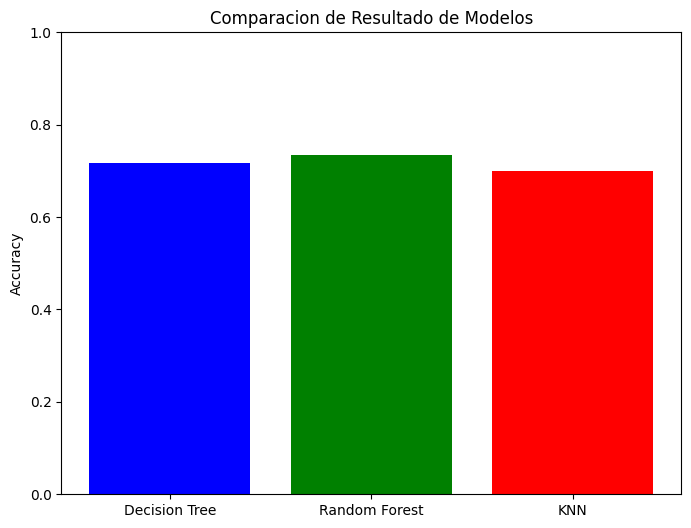

In [26]:
# grafico de barra para comparar los resultados
models = ['Decision Tree', 'Random Forest', 'KNN']

accuracy_scores = [accuracy_tree, accuracy_rf, accuracy_knn]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracy_scores, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparacion de Resultado de Modelos')
plt.show()

Segun el grafico, el mejor modelo es el Ramdom Forest

### *Parte 3: Optimización de Hiperparámetros*

**GridSearchCV:**
- Implementar GridSearchCV para realizar una búsqueda exhaustiva de los mejores hiperparámetros para el modelo seleccionado.
- Definir el espacio de búsqueda para los hiperparámetros relevantes.

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [28]:
# Optimizacion de hiperparametros de Arbol de Decision.
tree_params = {
    "model__max_depth": [3, 5, 7, 10, 15],
    "model__min_samples_split": [2, 5, 10, 15, 20],
    "model__min_samples_leaf": [1, 2, 4]
}

tree_grid = GridSearchCV(pipeline_tree, tree_params, cv=3, scoring="accuracy")
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'anaemia',
                                                                          'creatinine_phosphokinase',
                                                                          'diabetes',
                                                                          'ejection_fraction',
                                                                          'high_blood_pressure',
                                                                          'platelets',
                                                                          'serum_creatinine',
                                                                          'serum_sodium',
                                                                          'sex',
                                                                          'smoking',
                                                                          'time'])])),
                                       ('model', DecisionTreeClassifier())]),
             param_grid={'model__max_depth': [3, 5, 7, 10, 15],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10, 15, 20]},
             scoring='accuracy')

In [29]:
# Evaluación.
tree_best = tree_grid.best_estimator_
y_pred_tree = tree_best.predict(X_test)

print("Tree Regressor")
print("Mejores parámetros:", tree_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_tree))

Tree Regressor
Mejores parámetros: {'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 20}
Accuracy: 0.65


In [30]:
# Optimizacion de hiperparametros de Bosque de Arboles de Decision.
rf_params = {
    "model__n_estimators": [10, 50, 100, 200],
    "model__max_depth": [3, 5, 7, 10, 15],
    "model__min_samples_split": [2, 5, 10, 15, 20],
    "model__min_samples_leaf": [1, 2, 4]
}

rf_grid = GridSearchCV(pipeline_rf, rf_params, cv=3, scoring="accuracy")
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'anaemia',
                                                                          'creatinine_phosphokinase',
                                                                          'diabetes',
                                                                          'ejection_fraction',
                                                                          'high_blood_pressure',
                                                                          'platelets',
                                                                          'serum_creatinine',
                                                                          'serum_sodium',
                                                                          'sex',
                                                                          'smoking',
                                                                          'time'])])),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__max_depth': [3, 5, 7, 10, 15],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10, 15, 20],
                         'model__n_estimators': [10, 50, 100, 200]},
             scoring='accuracy')

In [31]:
# Evaluación.
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)

print("Ramdom Forest")
print("Mejores parámetros:", rf_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Ramdom Forest
Mejores parámetros: {'model__max_depth': 15, 'model__min_samples_leaf': 1, 'model__min_samples_split': 20, 'model__n_estimators': 10}
Accuracy: 0.6833333333333333


In [32]:
# Optimizacion de hiperparametros de KNN
knn_params = {
    "model__n_neighbors": [3, 5, 7, 10, 15],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]
}

knn_grid = GridSearchCV(pipeline_knn, knn_params, cv=3, scoring="accuracy")
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'anaemia',
                                                                          'creatinine_phosphokinase',
                                                                          'diabetes',
                                                                          'ejection_fraction',
                                                                          'high_blood_pressure',
                                                                          'platelets',
                                                                          'serum_creatinine',
                                                                          'serum_sodium',
                                                                          'sex',
                                                                          'smoking',
                                                                          'time'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 5, 7, 10, 15],
                         'model__p': [1, 2],
                         'model__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [33]:
# Evaluación.
knn_best = knn_grid.best_estimator_
y_pred_knn = knn_best.predict(X_test)

print("KNN")
print("Mejores parámetros:", knn_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN
Mejores parámetros: {'model__n_neighbors': 10, 'model__p': 2, 'model__weights': 'distance'}
Accuracy: 0.6833333333333333


**RandomizedSearchCV:**
- Implementar RandomizedSearchCV para realizar una búsqueda aleatoria de los mejores hiperparámetros, especialmente útil si el espacio de búsqueda es grande.

In [34]:
# Importo las librerias necesarias
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


Arbol de Decision

In [35]:
# Implementar RandomizedSearchCV para Arbol de Decision
tree_params_rand = {
    "model__max_depth": randint(3, 20),
    "model__min_samples_split": randint(2, 25),
    "model__min_samples_leaf": randint(1, 5)
}

tree_rand = RandomizedSearchCV(pipeline_tree, tree_params_rand, n_iter=50, cv=3, scoring="accuracy", random_state=42)
tree_rand.fit(X_train, y_train)

# Obtengo los mejores parametros para el modelo y su Accuracy
print("Mejores parámetros:", tree_rand.best_params_)
print("Accuracy:", accuracy_score(y_test, tree_rand.best_estimator_.predict(X_test)))

Mejores parámetros: {'model__max_depth': 13, 'model__min_samples_leaf': 4, 'model__min_samples_split': 22}
Accuracy: 0.7166666666666667


Ramdom Forest

In [36]:
# Implementar RandomizedSearchCV para Random Forest
rf_params_rand = {
    "model__n_estimators": randint(10, 200),
    "model__max_depth": randint(3, 20),
    "model__min_samples_split": randint(2, 25),
    "model__min_samples_leaf": randint(1, 5)
}

rf_rand = RandomizedSearchCV(pipeline_rf, rf_params_rand, n_iter=50, cv=3, scoring="accuracy", random_state=42)
rf_rand.fit(X_train, y_train)

# Obtengo los mejores parametros para el modelo y su Accuracy
print("Mejores parámetros:", rf_rand.best_params_)
print("Accuracy:", accuracy_score(y_test, rf_rand.best_estimator_.predict(X_test)))

Mejores parámetros: {'model__max_depth': 14, 'model__min_samples_leaf': 2, 'model__min_samples_split': 23, 'model__n_estimators': 98}
Accuracy: 0.7166666666666667


K-Neighbors

In [37]:
# Implementar RandomizedSearchCV para KNN
knn_params_rand = {
    "model__n_neighbors": randint(3, 20),
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]
}

knn_rand = RandomizedSearchCV(pipeline_knn, knn_params_rand, n_iter=50, cv=3, scoring="accuracy", random_state=42)
knn_rand.fit(X_train, y_train)
# Obtengo los mejores parametros para el modelo y su Accuracy
print("Mejores parámetros:", knn_rand.best_params_)
print("Accuracy:", accuracy_score(y_test, knn_rand.best_estimator_.predict(X_test)))

Mejores parámetros: {'model__n_neighbors': 8, 'model__p': 2, 'model__weights': 'distance'}
Accuracy: 0.7333333333333333


**Optuna:**
- Implementar Optuna para una optimización avanzada de los hiperparámetros, aprovechando técnicas como la optimización bayesiana y el pruning.

In [38]:
# Instalamos Optuna
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.4 MB/s eta 0:00:00


In [39]:
# Importamos Optuna
import optuna

Funcion para Arbol de Decisiones

In [40]:
# Funcion para Decision Tree
def objective_tree(trial):
    max_depth = trial.suggest_int("model__max_depth", 3, 20)
    min_samples_split = trial.suggest_int("model__min_samples_split", 2, 25)
    min_samples_leaf = trial.suggest_int("model__min_samples_leaf", 1, 5)

    pipeline_tree.set_params(model__max_depth=max_depth,
                             model__min_samples_split=min_samples_split,
                             model__min_samples_leaf=min_samples_leaf)

    score = cross_val_score(pipeline_tree, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score

# Creacion y Ejecucion de un Estudio Optuna para Decision Tree
study_tree = optuna.create_study(direction="maximize")
study_tree.optimize(objective_tree, n_trials=50)

print("Optuna para Decision Tree")
print("Mejores parámetros:", study_tree.best_params)
print("Best accuracy:", study_tree.best_value)

[I 2025-07-11 21:24:04,803] A new study created in memory with name: no-name-1a4248ad-8293-4d26-a7b2-e7b9e4483af2
[I 2025-07-11 21:24:05,018] Trial 0 finished with value: 0.7866033755274261 and parameters: {'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 3}. Best is trial 0 with value: 0.7866033755274261.
[I 2025-07-11 21:24:05,177] Trial 1 finished with value: 0.7949367088607596 and parameters: {'model__max_depth': 17, 'model__min_samples_split': 16, 'model__min_samples_leaf': 5}. Best is trial 1 with value: 0.7949367088607596.
[I 2025-07-11 21:24:05,332] Trial 2 finished with value: 0.7616033755274261 and parameters: {'model__max_depth': 12, 'model__min_samples_split': 11, 'model__min_samples_leaf': 1}. Best is trial 1 with value: 0.7949367088607596.
[I 2025-07-11 21:24:05,564] Trial 3 finished with value: 0.7907700421940929 and parameters: {'model__max_depth': 5, 'model__min_samples_split': 15, 'model__min_samples_leaf': 5}. Best is trial 1 with val

Optuna para Decision Tree
Mejores parámetros: {'model__max_depth': 18, 'model__min_samples_split': 25, 'model__min_samples_leaf': 4}
Best accuracy: 0.8660864978902953


In [41]:
# Funcion para Random Forest
def objective_rf(trial):
    n_estimators = trial.suggest_int("model__n_estimators", 10, 200)
    max_depth = trial.suggest_int("model__max_depth", 3, 20)
    min_samples_split = trial.suggest_int("model__min_samples_split", 2, 25)
    min_samples_leaf = trial.suggest_int("model__min_samples_leaf", 1, 5)

    pipeline_rf.set_params(model__n_estimators=n_estimators,
                           model__max_depth=max_depth,
                           model__min_samples_split=min_samples_split,
                           model__min_samples_leaf=min_samples_leaf)

    score = cross_val_score(pipeline_rf, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score

# # Creacion y Ejecucion de un Estudio Optuna para Random Forest
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=50)

print("Optuna para Ramdom forest")
print("Mejores parámetros:", study_rf.best_params)
print("Best accuracy:", study_rf.best_value)

[I 2025-07-11 21:24:29,063] A new study created in memory with name: no-name-0afff430-4877-413d-a9e0-55d81307ddcb
[I 2025-07-11 21:24:29,218] Trial 0 finished with value: 0.8618670886075949 and parameters: {'model__n_estimators': 25, 'model__max_depth': 12, 'model__min_samples_split': 8, 'model__min_samples_leaf': 2}. Best is trial 0 with value: 0.8618670886075949.
[I 2025-07-11 21:24:29,809] Trial 1 finished with value: 0.8702531645569621 and parameters: {'model__n_estimators': 123, 'model__max_depth': 18, 'model__min_samples_split': 19, 'model__min_samples_leaf': 5}. Best is trial 1 with value: 0.8702531645569621.
[I 2025-07-11 21:24:30,293] Trial 2 finished with value: 0.8744198312236287 and parameters: {'model__n_estimators': 96, 'model__max_depth': 5, 'model__min_samples_split': 11, 'model__min_samples_leaf': 2}. Best is trial 2 with value: 0.8744198312236287.
[I 2025-07-11 21:24:30,768] Trial 3 finished with value: 0.8619198312236288 and parameters: {'model__n_estimators': 79, 'm

Optuna para Ramdom forest
Mejores parámetros: {'model__n_estimators': 184, 'model__max_depth': 12, 'model__min_samples_split': 12, 'model__min_samples_leaf': 4}
Best accuracy: 0.8827531645569621


In [42]:
# Funcion para KNN
def objective_knn(trial):
    n_neighbors = trial.suggest_int("model__n_neighbors", 3, 20)
    weights = trial.suggest_categorical("model__weights", ["uniform", "distance"])
    p = trial.suggest_categorical("model__p", [1, 2])

    pipeline_knn.set_params(model__n_neighbors=n_neighbors,
                            model__weights=weights,
                            model__p=p)

    score = cross_val_score(pipeline_knn, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score

# Creacion y Ejecucion de un Estudio Optuna para KNN
study_knn = optuna.create_study(direction="maximize")
study_knn.optimize(objective_knn, n_trials=50)

print("Optuna para KNN")
print("Mejores parámetros:", study_knn.best_params)
print("Best accuracy:", study_knn.best_value)

[I 2025-07-11 21:25:05,859] A new study created in memory with name: no-name-33e6fe88-2c00-4379-b028-f92d7e8abec4
[I 2025-07-11 21:25:05,900] Trial 0 finished with value: 0.7530063291139241 and parameters: {'model__n_neighbors': 8, 'model__weights': 'distance', 'model__p': 1}. Best is trial 0 with value: 0.7530063291139241.
[I 2025-07-11 21:25:05,949] Trial 1 finished with value: 0.7447257383966245 and parameters: {'model__n_neighbors': 13, 'model__weights': 'uniform', 'model__p': 1}. Best is trial 0 with value: 0.7530063291139241.
[I 2025-07-11 21:25:05,985] Trial 2 finished with value: 0.7530063291139241 and parameters: {'model__n_neighbors': 10, 'model__weights': 'distance', 'model__p': 1}. Best is trial 0 with value: 0.7530063291139241.
[I 2025-07-11 21:25:06,034] Trial 3 finished with value: 0.7029535864978902 and parameters: {'model__n_neighbors': 19, 'model__weights': 'uniform', 'model__p': 2}. Best is trial 0 with value: 0.7530063291139241.
[I 2025-07-11 21:25:06,074] Trial 4 f

Optuna para KNN
Mejores parámetros: {'model__n_neighbors': 15, 'model__weights': 'distance', 'model__p': 1}
Best accuracy: 0.7573312236286919


**Evaluación de Modelos Optimizados:**
- Entrenar el modelo con los mejores hiperparámetros encontrados y evaluar su rendimiento en el conjunto de prueba.
- Comparar el rendimiento del modelo optimizado con el modelo inicial.

In [43]:
# Optuna para Decision Tree
# Mejores parámetros: {'model__max_depth': 18, 'model__min_samples_split': 25, 'model__min_samples_leaf': 4}
# Best accuracy: 0.8660864978902953

tree = DecisionTreeClassifier(max_depth=18, min_samples_leaf=4, min_samples_split=25)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print("Arbol de Decision")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))

Arbol de Decision
Accuracy: 0.7166666666666667


In [44]:
# Optuna para Ramdom forest
# Mejores parámetros: {'model__n_estimators': 184, 'model__max_depth': 12, 'model__min_samples_split': 12, 'model__min_samples_leaf': 4}
# Best accuracy: 0.8827531645569621

rf = RandomForestClassifier(max_depth=12, min_samples_leaf=4, min_samples_split=12, n_estimators=184)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Ramdom Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Ramdom Forest
Accuracy: 0.75


In [45]:
# Optuna para KNN
# Mejores parámetros: {'model__n_neighbors': 15, 'model__weights': 'distance', 'model__p': 1}
# Best accuracy: 0.7573312236286919

knn = KNeighborsClassifier(n_neighbors= 15, p=1, weights='distance')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("K_Neighbors")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))


K_Neighbors
Accuracy: 0.6166666666666667


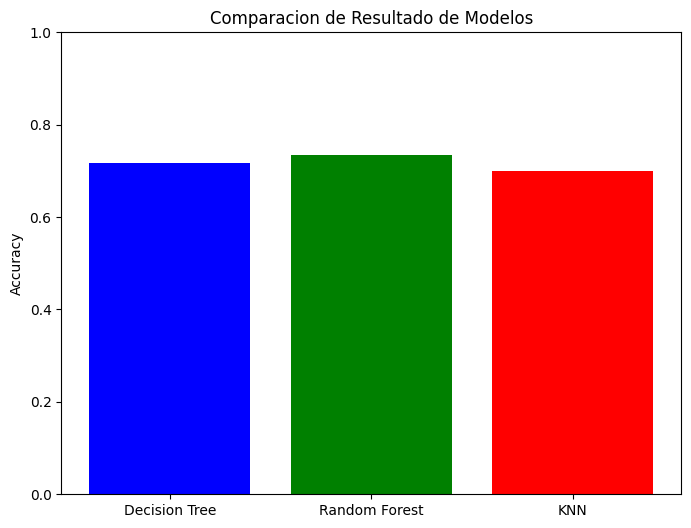

In [46]:
# Grafico los resultados
models = ['Decision Tree', 'Random Forest', 'KNN']

accuracy_scores = [accuracy_tree, accuracy_rf, accuracy_knn]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracy_scores, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparacion de Resultado de Modelos')
plt.show()



Probando en reiteradas ocasiones, basandome en Optuna, el algoritmo que me dio mejor resultado fue Ramdom Forest con un 75% de Accuracy

### **Parte 4: Documentación y Entrega**

**Documentación del Proceso:**
- Documentar todos los pasos del preprocesamiento, selección de técnica y optimización en un notebook de Jupyter.
- Incluir explicaciones detalladas y justificaciones para cada decisión tomada.

**Subida a GitHub:**
- Actualizar el repositorio de GitHub con los notebooks de preprocesamiento, selección de técnica y optimización.
- Incluir los resultados de la optimización y la comparación de modelos.
- Crear un tag de liberación (v2.0.0) para esta versión del proyecto.